In [1]:

#imports
import importlib
import sys
import pandas as pd
import numpy as np
from collections import Counter
import string
import collections
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import dbscan
from sklearn.neighbors import NearestNeighbors
from factor_analyzer import FactorAnalyzer
from Levenshtein import jaro_winkler
from kneed import KneeLocator
from os import path



#custom imports from python files in scripts folder
import custom_funcs_for_wf as myFuncs

#reload custom modules
_ = importlib.reload(sys.modules['custom_funcs_for_wf']) #wreloads the functions without needing to restart the kernel

# Read the Data

In [2]:
cooked_directory = r'data/'

ascend_ctf_data = True #TODO True if using 300_wf.csv from ASCEND, else set to false and add file name below
if ascend_ctf_data:
    task_data_df = myFuncs.read_ascend_ctf_data(cooked_directory, 'ecsc')
else:
    csv_file_name = 'random_name.csv' #TODO if you are not using CTF data, change this to the actual file name
    task_data_df = pd.read_csv(path.join(cooked_directory, csv_file_name))

/Users/e36224/Documents/Paper Code/task-explorer-pipeline/custom_funcs_for_wf.py:50: DtypeWarning: Columns (3,4,5,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_of_saved_csv)


# Factor Analysis + Hiearchical Clustering

In [3]:
task_data_df = myFuncs.clean_terms(task_data_df) #clean actions
if ascend_ctf_data:
    bad_actions, all_action_types = myFuncs.get_bad_actions(task_data_df['action'], path.join(cooked_directory, '200_terminal_features.csv'))
else:
    bad_actions, all_action_types = myFuncs.get_bad_actions(task_data_df['action'])

## <font color='yellow'> [TF Threshold] Manually Reducing Number Of Actions By Using TF</font>

### Here we look at the term frequencies of actions in the task, then choose the "most common" by both a drop off of frequency and a drop off in "importance" to solving.

In [4]:
print(f'Tasks in data: {np.unique(task_data_df['task'])}')

Tasks in data: ['cult-1' 'cult-5' 'loss-1a' 'loss-1b' 'rep-8a' 'rep-8b']


In [5]:
task = 'loss-1b' #TODO choose the task here, use the cell above to choose the task

#participants_to_exclude = ['P19293','P46096','P46831','P51605','P58671','P80489','P92975'] #bad users for hitb loss 1b (no actions or just weird data)
actions_in_task = task_data_df[task_data_df['task'] == task]['action'].unique()

actions_to_include = [action for action in actions_in_task if action in all_action_types]

term_counter = myFuncs.get_TF_from_runs_in_task(task, actions_to_include, task_data_df)
term_counter

Counter({'python': 235,
         'hydra': 170,
         'grep': 75,
         'man': 30,
         'ffuf': 18,
         'cut': 16,
         'for': 9,
         'mv': 8,
         'exit': 7,
         'dirb': 7,
         'curl': 7,
         'unzip': 6,
         'gzip': 5,
         'strings': 5,
         'nmap': 5,
         'head': 4,
         'setxkbmap': 4,
         'cp': 3,
         'pwd': 3,
         'history': 3,
         'mkdir': 2,
         'wc': 2,
         'chmod': 2,
         'sort': 2,
         'ping': 2,
         'sqlite3': 2,
         'searchsploit': 1,
         'ld': 1,
         'find': 1,
         'wfuzz': 1,
         'xclip': 1,
         'touch': 1,
         'rm': 1,
         'which': 1,
         'msfconsole': 1,
         'netstat': 1,
         'nc': 1,
         'ps': 1,
         'docker': 1})

In [6]:
TF_threshold = 4
actions_to_include_in_task = []
for key, value in term_counter.items():
    if value >= TF_threshold:
            actions_to_include_in_task.append(key)

## Turn runs into low dimensional vectors as TF-IDF scores

### <font color='yellow'>[n] The length an action trace must be to be included in analysis (Typically you want to look at the # of users) </font>
### <font color='yellow'>[terms_to_concat_dict] TEP UPDATED TO AUTOMATICALLY DO THIS STEP, BUT CAN STILL DO IT MANUALLY - Merging highly correlated actions to solve singular matrix error in factor analysis </font>


In [7]:
import warnings
warnings.filterwarnings("ignore") #ignores an sklearn warning for a deprecated usage that another package still uses (they will update it once it becomes broken)
terms_to_concat_dict = {
                    'cult-1': 
                        {
                            """'tcpdump': 'tcpdumppingnslookupcrunchifconfig',
                            'ping': 'tcpdumppingnslookupcrunchifconfig',
                            'nslookup': 'tcpdumppingnslookupcrunchifconfig',
                            'crunch': 'tcpdumppingnslookupcrunchifconfig',
                            'ifconfig': 'tcpdumppingnslookupcrunchifconfig',
                            'gzip': 'gzipffuf',
                            'ffuf': 'gzipffuf',""" #example of what it would look like if you manually did it
                        },
                    'cult-5': {},
                    'conf-5b': {},
                    'conf-5a': {},
                    'anch-1b': {},
                    'anch-1a': {},
                }
parameters = {
    'terms_to_concat_dict': terms_to_concat_dict,
    'n': {
        task:3
    }

}
actions_to_include = actions_to_include_in_task



runs, participants_included, bot_data_df, n_factors_greater_than_1 = myFuncs.get_n_comps_and_prune_correlations(actions_to_include_in_task, task, task_data_df, parameters)



In [8]:
bot_data_df.columns

Index(['curl', 'cut', 'dirb', 'exit', 'ffuf', 'for', 'grep', 'gzip', 'head',
       'hydra', 'man', 'mv', 'nmap', 'python', 'setxkbmap', 'strings',
       'unzip'],
      dtype='object')

In [9]:
print(f'There are {bot_data_df.shape[0]} users and {bot_data_df.shape[1]} actions included')

There are 42 users and 17 actions included


## bot

In [10]:
# find/delete columns that make the matrix a single matrix (I DO NOT USE IT CURRENTLY AS ALL DATASETS SEEM TO BE OKAY NOW)
corr = bot_data_df.corr()
np.fill_diagonal(corr.values, np.nan)
corr_subset = corr[corr.isin([1.0]).any(axis=1)]
#corr_subset_T = corr_subset.T
#new_bot_data_df = bot_data_df.drop(corr_subset_T[corr_subset_T.isin([1.0]).any(axis=1)].columns, axis=1)

In [11]:
#find the number of  factors by using the kaiser criterion (# of eigenvalues > 1). an eigenvalue of 1 means that the factor represents the same information as one variable 
n_comps = bot_data_df.shape[1]-1
bot_not_rot = FactorAnalyzer(n_factors=n_comps)
factors = bot_not_rot.fit(bot_data_df)
eigenvalues, common_factor_eigenvalues = bot_not_rot.get_eigenvalues()
n_factors_greater_than_1_test = len([eigenvalue for eigenvalue in eigenvalues if eigenvalue > 1])

In [12]:
#rotate factors
#oblique rotations: direct oblimin & promax
n_comps = n_factors_greater_than_1
bot = FactorAnalyzer(n_factors=n_comps, rotation='oblimin')
factors = bot.fit(bot_data_df)

In [13]:
#transform data into rotated factor scores
rotated_factor_scores = bot.transform(bot_data_df)

## Hierarchical Clustering the Rotated Factor Scores

In [14]:
print(f'there are {rotated_factor_scores.shape[0]} users and {rotated_factor_scores.shape[1]} factors')

there are 42 users and 8 factors


Elbow found at 11 clusters


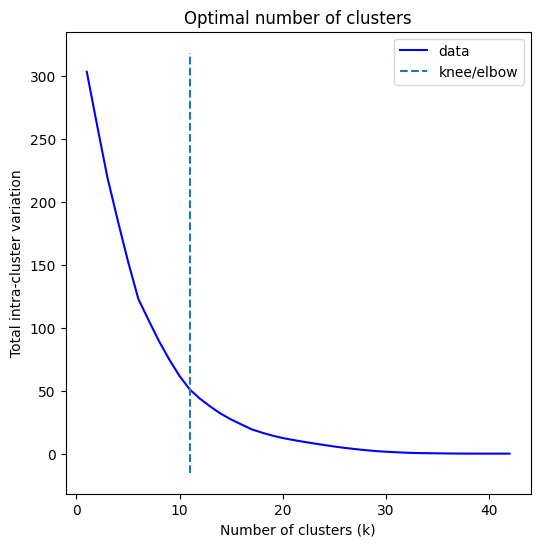

In [15]:
#use elbow method to choose the number of clusters
from matplotlib import pyplot as plt

WSS=myFuncs.wss_calculation(rotated_factor_scores.shape[0], rotated_factor_scores)

cluster_range = range(1, rotated_factor_scores.shape[0]+1)

# get knee using the kneedle algorithm
kneedle = KneeLocator(cluster_range, WSS,  S=1.0, curve="convex", direction="decreasing")
kneedle.plot_knee(xlabel='Number of clusters (k)',ylabel='Total intra-cluster variation',title='Optimal number of clusters')
print(f'Elbow found at {kneedle.knee} clusters')

In [16]:
#cluster for the best number of clusters found with elbow method
n_clusters = kneedle.knee
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(rotated_factor_scores)

In [17]:
#see what actions comprise the found clusters

for clust_num in np.unique(clustering.labels_):
    print('---------------------------------------------')
    print(f'BOT STRATEGY {clust_num}')
    print('---------------------------------------------')
    num_users = 0
    participants_in_cluster = []
    for key, value in collections.OrderedDict(sorted(dict(zip(participants_included,clustering.labels_)).items())).items():
        if value == clust_num:
            participants_in_cluster.append(key)
            num_users += 1
            #print(f'{key}:{value}')

    print(f'number of users in cluster {clust_num}: {num_users}\n')

    particpant_runs_dict = collections.OrderedDict(sorted(dict(zip(participants_included,runs)).items()))
    actions_in_cluster_counter = Counter()
    for participant in participants_in_cluster:
        actions_for_participant_counter = Counter()
        for action in particpant_runs_dict[participant]:
            actions_for_participant_counter[action] = 1
        actions_in_cluster_counter += actions_for_participant_counter

    print(f'number of users that used each action in strategy {clust_num}')
    print(actions_in_cluster_counter)  

    print('\n\n')

---------------------------------------------
BOT STRATEGY 0
---------------------------------------------
number of users in cluster 0: 10

number of users that used each action in strategy 0
Counter({'man': 10, 'hydra': 9, 'python': 7, 'gzip': 1, 'unzip': 1, 'grep': 1, 'ffuf': 1, 'nmap': 1})



---------------------------------------------
BOT STRATEGY 1
---------------------------------------------
number of users in cluster 1: 12

number of users that used each action in strategy 1
Counter({'python': 12, 'hydra': 7, 'unzip': 1, 'head': 1, 'setxkbmap': 1})



---------------------------------------------
BOT STRATEGY 2
---------------------------------------------
number of users in cluster 2: 1

number of users that used each action in strategy 2
Counter({'python': 1, 'curl': 1, 'grep': 1, 'cut': 1, 'man': 1, 'for': 1})



---------------------------------------------
BOT STRATEGY 3
---------------------------------------------
number of users in cluster 3: 4

number of users that 

In [18]:
#reduce the rotated factor scores down to 2 dimensions so we can visualize on 2d plot
pca = PCA(n_components = 2)
pca.fit(rotated_factor_scores)
reduced_dimenions = pca.transform(rotated_factor_scores)

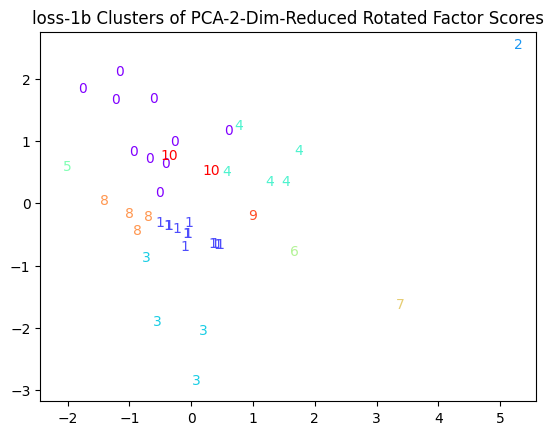

In [19]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, clustering.n_clusters_)) #get n_clusters colors to plot
plt.scatter(reduced_dimenions[:, 0], reduced_dimenions[:, 1], alpha=0) #scatter sso we have a plot the size of points (was plotting text points outside plot otherwise)
for i, point in enumerate(reduced_dimenions): #plot points as their cluster label
    plt.text(point[0], point[1], clustering.labels_[i], label = clustering.labels_[i], fontsize=10, color=colors[clustering.labels_[i]])
plt.title(f'{task} Clusters of PCA-2-Dim-Reduced Rotated Factor Scores')
plt.show()

## Clustering Previously Found Intra-Cluster Runs Using Edit Distance

### Get the runs based on the previous clusters

In [20]:
#getting the runs, now with cluster labels from bot clustering
rows = []
for i in range(len(participants_included)): #make new rows with participant, cluster label, and run
    participant = participants_included[i]
    label = clustering.labels_[i]
    run = runs[i]
    rows.append([participant, label, run])
runs_with_bot_labels = pd.DataFrame(rows, columns=['participant','bot_cluster_label','run'])

## Turn runs into word strings

In [21]:
#get dictionary that map actions to symbols
symbols = string.printable #get all ASCII printable characters in python
terms_included_in_task = list(bot_data_df.columns) #all termns that were used to cluster in this task
term_to_symbol = dict()

for i,term in enumerate(terms_included_in_task): #make a dictionary of string action: symbol representing string action
    term_to_symbol[term] = symbols[i]
    
#turn arrays of string actions into strings of symbol actions
runs_as_strings = []
for run in runs_with_bot_labels['run']: #for each run we used
    run_as_string = ''
    for term in run: #turn the run into a string using symbols
        run_as_string += term_to_symbol[term]
    runs_as_strings.append(run_as_string)
runs_with_bot_labels['string_run'] = runs_as_strings #add new column

## Cluster using Single-Link Hierarchical Clustering Based on Jaro-Winkler Word Similarity as distance metric

### Note: Jaro-Winkler is not a "true" metric, as it fails the triangle inequality test, but since we are using dbscan/ single-link hierarchical clustering it is okay. If we were to use a clustering approach like K-Means, it would require a true metric.

-------------------------------------------
BOT_STRATEGY: 0
-------------------------------------------
______ECHO_STRATEGY:_-1_____
['hydra', 'man', 'man', 'hydra', 'man', 'man', 'hydra', 'man', 'hydra', 'hydra', 'hydra']
['python', 'python', 'grep', 'grep', 'man', 'man', 'ffuf', 'ffuf', 'ffuf', 'ffuf', 'ffuf', 'ffuf', 'ffuf', 'ffuf', 'ffuf', 'ffuf', 'ffuf']
______ECHO_STRATEGY:_0_____
['hydra', 'hydra', 'man', 'hydra', 'gzip', 'gzip', 'gzip', 'gzip', 'gzip', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'python']
['hydra', 'hydra', 'hydra', 'hydra', 'man', 'man', 'man', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'hydra', 'python']
______ECHO_STRATEGY:_1_____
['hydra', 'python', 'python', 'python', 'hydra', 'man', 'python', 'python', 'python', 'python', 'python', 'python', 'hydra']
['unzip', 'unzip', 'python', 'python', 'python', 'python', 'python', 'python', 'python', 'python', 'python', 'python', 'hydra', 'man', 'hydra', 'python

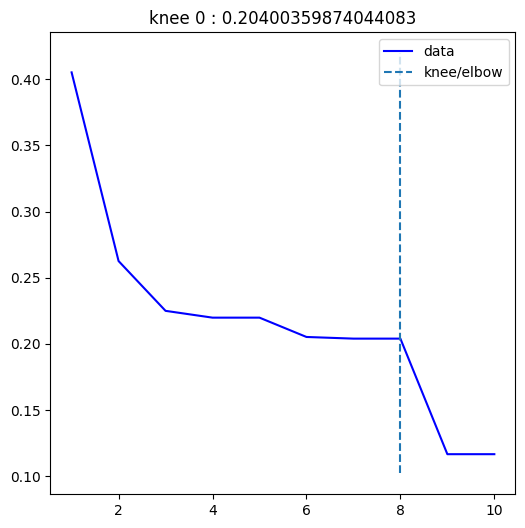

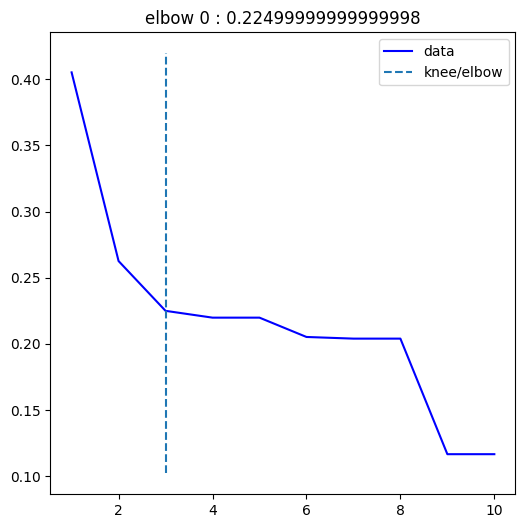

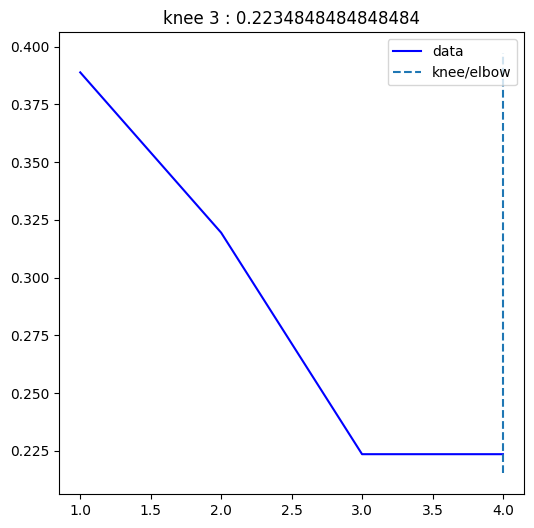

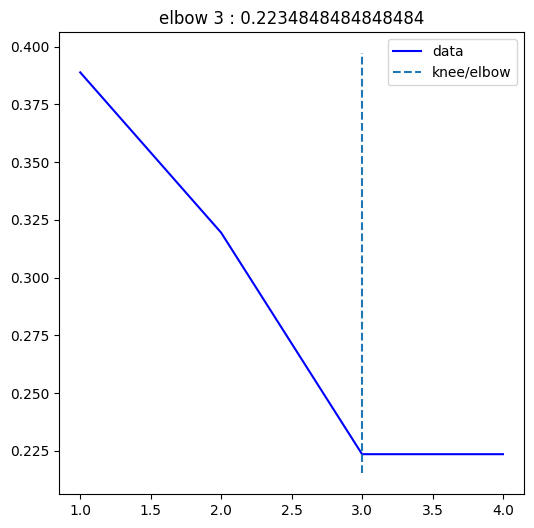

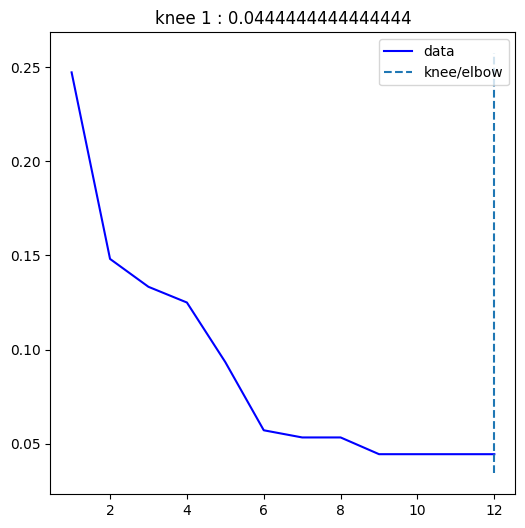

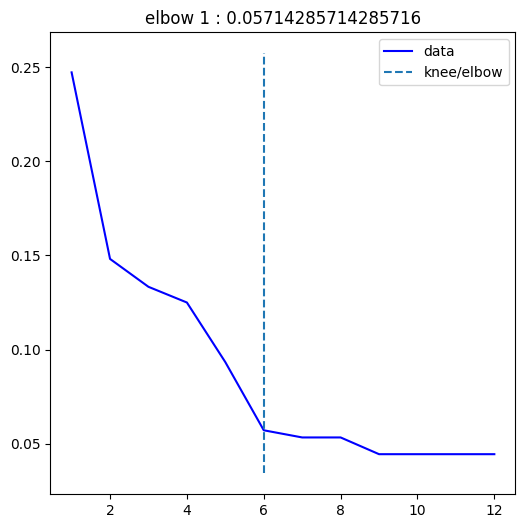

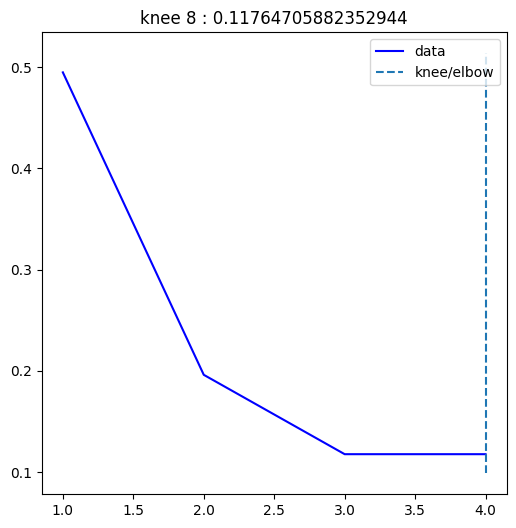

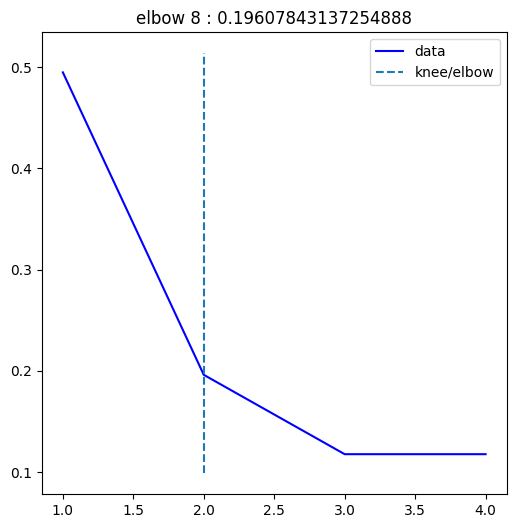

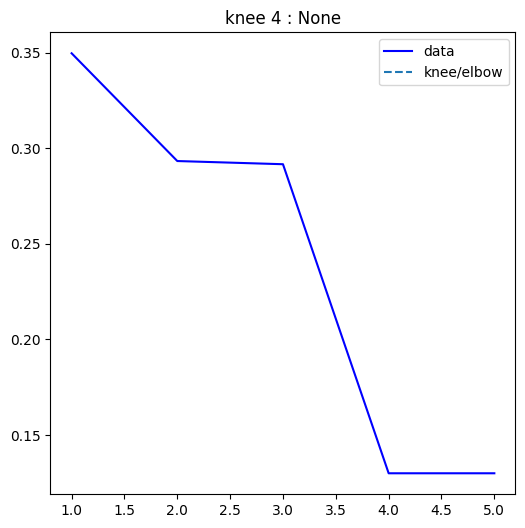

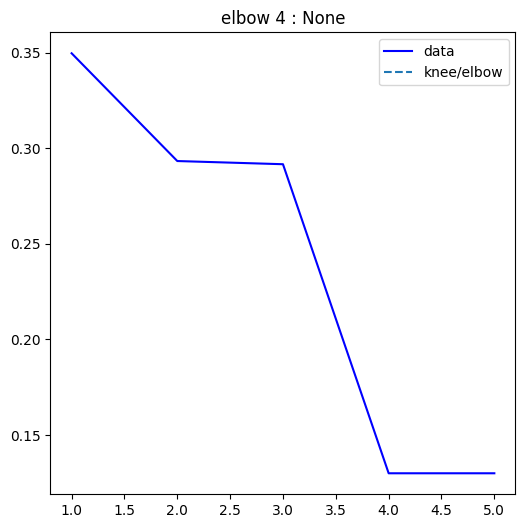

In [22]:
results = []

for label in runs_with_bot_labels['bot_cluster_label'].unique(): #for each cluster found in bot clustering
    rows_with_label = runs_with_bot_labels[runs_with_bot_labels['bot_cluster_label'] == label] #get the runs that match this cluster label
    #print(rows_with_label)
    runs_with_label = list(rows_with_label['string_run']) #get the string runs
    
    #define the distance metric for dbscan
    #uses 1-jaro_winkler as distance metric. jaro-winkler gives similarity score normalized between 0 and 1.
    #intuitively, two strings that are compositionally similar will have a lower (closer) distance
    def jaro_winkler_metric(x, y): 
        i, j = int(x[0]), int(y[0])     # extract indices
        return 1-jaro_winkler(runs_with_label[i], runs_with_label[j]) #get distance
    
    X = np.arange(len(runs_with_label)).reshape(-1, 1) #get indices of runs to feed into dbscan
    min_pts = 2
    
    
    #find nearest neighbors
    epsilon = 0.15
    if len(X) > min_pts:
        k = min_pts
        neighbors = NearestNeighbors(n_neighbors=k, n_jobs=1, metric=jaro_winkler_metric)
        neighbors.fit(X)
        dists, inds = neighbors.kneighbors(X)
        distances = [dist[k-1] for dist in dists]
        distances = np.sort(distances)[::-1]
        #print(distances)
        cluster_range = range(1, len(distances)+1)
        kneedle = KneeLocator(cluster_range, distances,  S=1.0, curve="concave", direction="decreasing")
        kneedle.plot_knee(title=f'knee {label} : {kneedle.knee_y}')
        knee_epsilon = kneedle.knee_y
        '''print(f'knee {label}: {epsilon}')
        print(distances)'''
        
        kneedle = KneeLocator(cluster_range, distances,  S=1.0, curve="convex", direction="decreasing")
        kneedle.plot_knee(title=f'elbow {label} : {kneedle.knee_y}')
        elbow_epsilon = kneedle.knee_y
        '''print(f'elbow {label}: {epsilon}')
        print(distances)'''
        if knee_epsilon and elbow_epsilon:
            epsilon = max(knee_epsilon, elbow_epsilon)
        elif knee_epsilon:
            epsilon = knee_epsilon
        elif elbow_epsilon:
            epsilon = elbow_epsilon
        else:
            epsilon = np.median(distances)
            
        if epsilon == distances[-1]:
            epsilon = np.median(distances)
    elif len(X) == min_pts:
        epsilon = .2 #means that their similarity is .8 #TODO empirical way to compute/decide this?
        
    core_samples, db_labels = dbscan(X, metric=jaro_winkler_metric, eps=epsilon, min_samples=min_pts) #run dbscan using custom distance metric
    
    #print out results for each bot cluster label
    print(f'-------------------------------------------\nBOT_STRATEGY: {label}\n-------------------------------------------')
    #print(f'-------------------------------------------\nbot_LABEL: {label} EPSILON: {epsilon}\n-----------------------------------')
    for db_label in np.unique(db_labels):
        print(f'______ECHO_STRATEGY:_{db_label}_____')
        for i, all_db_label in enumerate(db_labels):
            if all_db_label == db_label:
                
                print(f'{list(rows_with_label["run"])[i]}')
                new_result = [list(rows_with_label['participant'])[i], list(rows_with_label['bot_cluster_label'])[i], db_label]
                results.append(new_result)


In [23]:
results

[['P11050', 0, np.int64(-1)],
 ['P77959', 0, np.int64(-1)],
 ['P47735', 0, np.int64(0)],
 ['P94232', 0, np.int64(0)],
 ['P49781', 0, np.int64(1)],
 ['P62648', 0, np.int64(1)],
 ['P81319', 0, np.int64(1)],
 ['P74325', 0, np.int64(2)],
 ['P93019', 0, np.int64(2)],
 ['P95713', 0, np.int64(2)],
 ['P29730', 3, np.int64(-1)],
 ['P65546', 3, np.int64(-1)],
 ['P12167', 3, np.int64(0)],
 ['P29729', 3, np.int64(0)],
 ['P16792', 1, np.int64(-1)],
 ['P54038', 1, np.int64(-1)],
 ['P62161', 1, np.int64(-1)],
 ['P66492', 1, np.int64(-1)],
 ['P93411', 1, np.int64(-1)],
 ['P13881', 1, np.int64(0)],
 ['P20253', 1, np.int64(0)],
 ['P36076', 1, np.int64(1)],
 ['P50785', 1, np.int64(1)],
 ['P60389', 1, np.int64(1)],
 ['P74261', 1, np.int64(1)],
 ['P99129', 1, np.int64(1)],
 ['P26759', 5, np.int64(-1)],
 ['P52906', 6, np.int64(-1)],
 ['P94583', 8, np.int64(-1)],
 ['P57917', 8, np.int64(0)],
 ['P76927', 8, np.int64(0)],
 ['P83541', 8, np.int64(0)],
 ['P66711', 4, np.int64(-1)],
 ['P83392', 4, np.int64(-1)],
